### Visualization of condition-averaged population trajectories in PCA space for different belief partition conditions
- start with feat
- Ex. Low, High SQUARE, High not SQUARE
- filter beh for correct, chose square

In [52]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.pseudo_classifier_utils as pseudo_classifier_utils
import utils.classifier_utils as classifier_utils

import utils.io_utils as io_utils

import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import matplotlib
import utils.spike_utils as spike_utils
import utils.subspace_utils as subspace_utils
from trial_splitters.condition_trial_splitter import ConditionTrialSplitter 
from utils.session_data import SessionData
from constants.behavioral_constants import *
from constants.decoding_constants import *
import seaborn as sns
from scripts.anova_analysis.anova_configs import *
from scripts.anova_analysis.run_anova import load_data
import scipy
import argparse
import copy
from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)
import itertools
from tqdm import tqdm
from sklearn.decomposition import PCA
import plotly.express as px

import seaborn.objects as so
tqdm.pandas()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
subject = "SA"
FEATS_PATH = "/data/patrick_res/sessions/{sub}/feats_at_least_3blocks.pickle"
SESSIONS_PATH = "/data/patrick_res/sessions/{sub}/valid_sessions.pickle"
feats = pd.read_pickle(FEATS_PATH.format(sub=subject))
valid_sess = pd.read_pickle(SESSIONS_PATH.format(sub=subject))

In [54]:
args = argparse.Namespace(
    **AnovaConfigs()._asdict()
)
args.trial_event = "FeedbackOnsetLong"
args.conditions = ["BeliefConf", "BeliefPartition"]
args.beh_filters = {"Response": "Correct", "Choice": "Chose"}
args.trial_interval = get_trial_interval(args.trial_event)
feat_row = feats.iloc[0]
args.feat = feat_row.feat

In [55]:
def compute_cond_averaged_pc_trajectories(data, column):
    cond_avg = data.groupby(["PseudoUnitID", column, "Time"]).FiringRate.mean().reset_index(name="AvgFiringRate")
    zscored = spike_utils.zscore_frs(cond_avg, group_cols=["PseudoUnitID"], mode="AvgFiringRate")
    flattened = zscored.groupby(["BeliefPartition", "Time"]).apply(lambda x: x.sort_values(by="PseudoUnitID").ZAvgFiringRate.values).reset_index(name="ZAvgFiringRates")
    np_arr = np.vstack(flattened.ZAvgFiringRates.values)

    pca = PCA(n_components=10)
    pca.fit(np_arr)

    transformed = pca.fit_transform(np_arr)
    pca_df = pd.DataFrame(data=transformed, columns=[f"PC{i}" for i in range(10)])
    pca_res = pd.concat((flattened, pca_df), axis=1)

    return pca_res, pca
    
    

100%|██████████| 22/22 [00:23<00:00,  1.07s/it]
/src/wcst_decode/utils/spike_utils.py:280: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  return frs.groupby(group_cols).apply(zscore_unit).reset_index(drop=True)
100%|██████████| 22/22 [00:19<00:00,  1.10it/s]
/src/wcst_decode/utils/spike_utils.py:280: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this wa

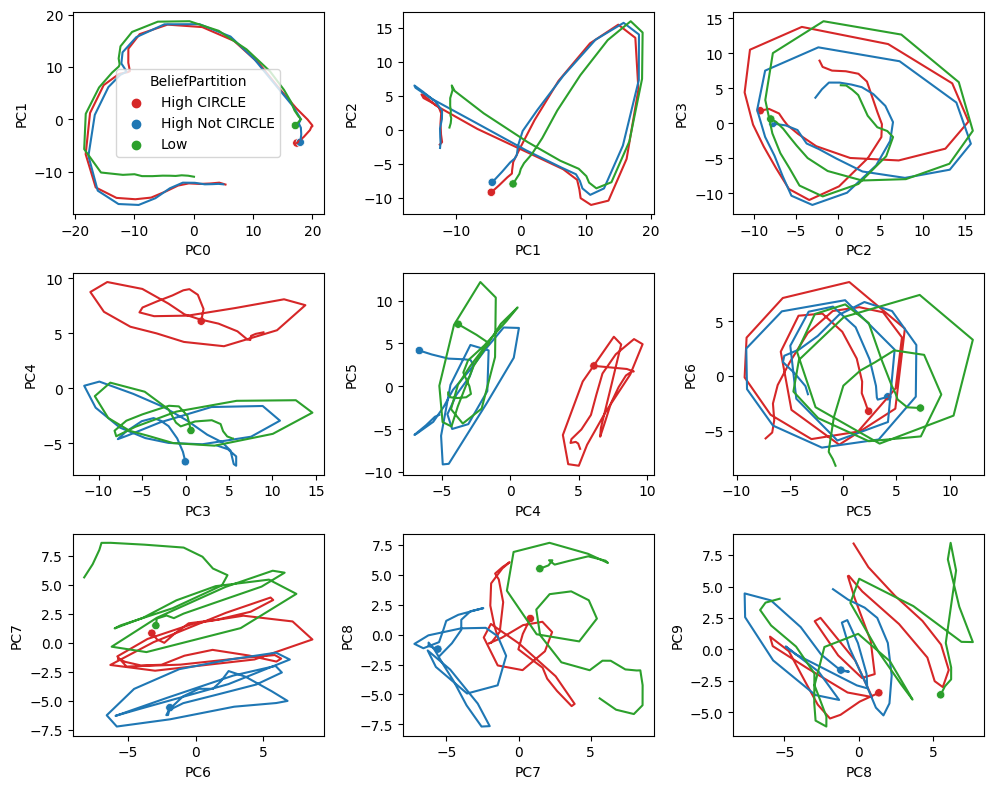

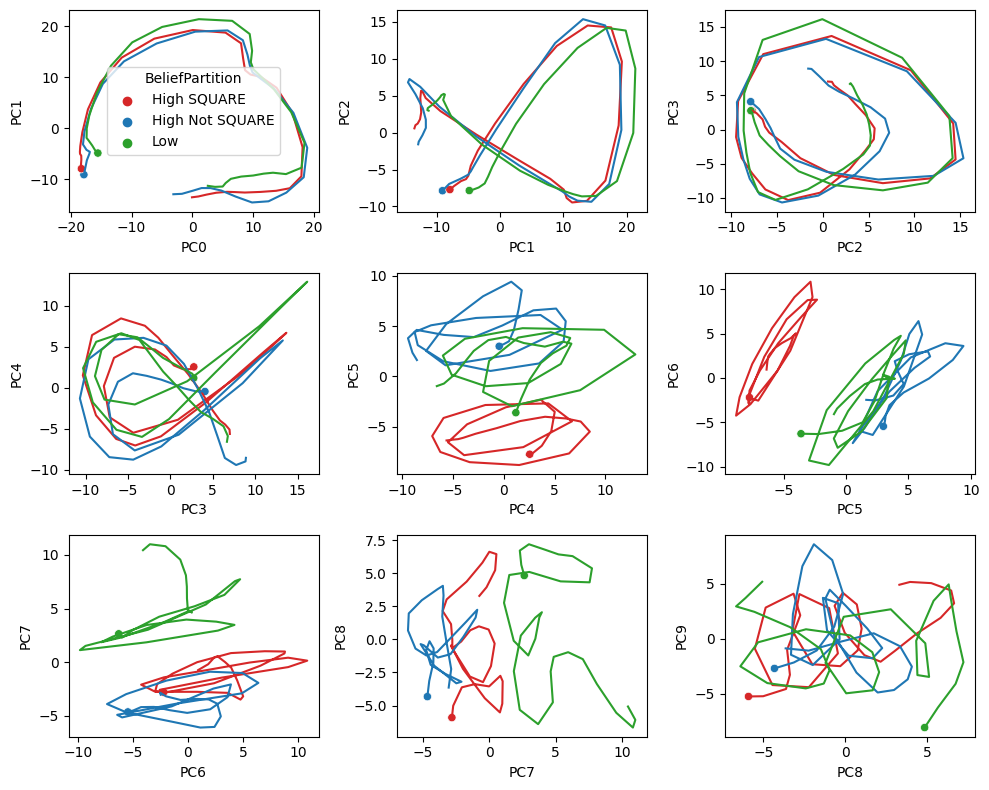

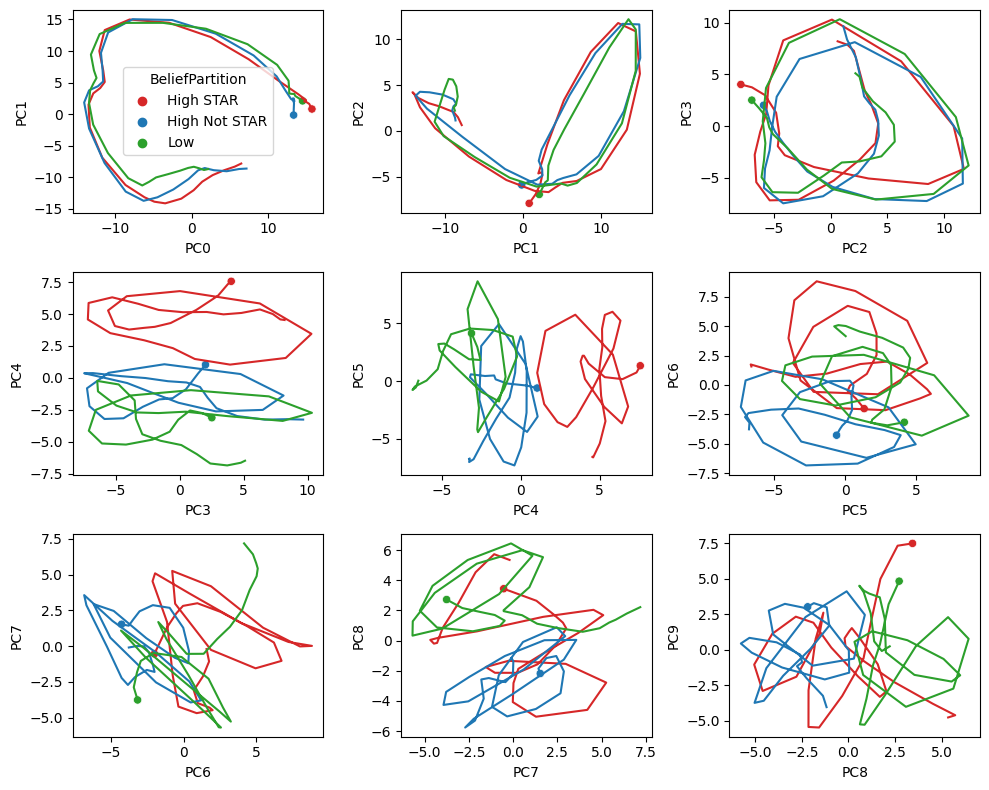

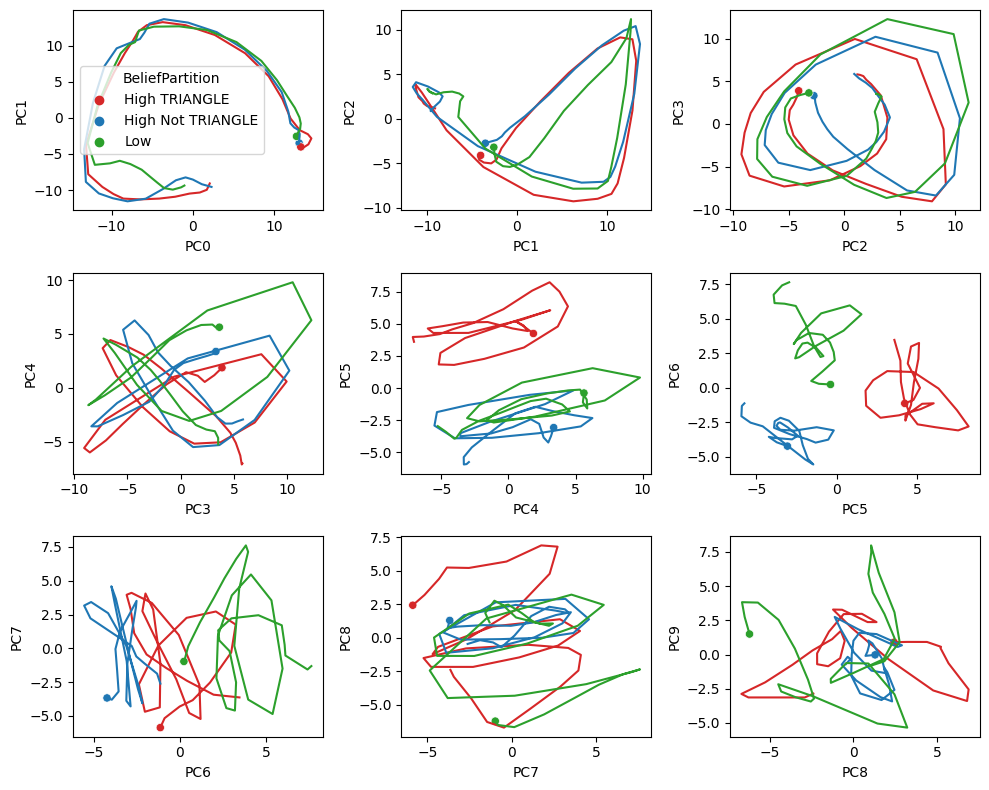

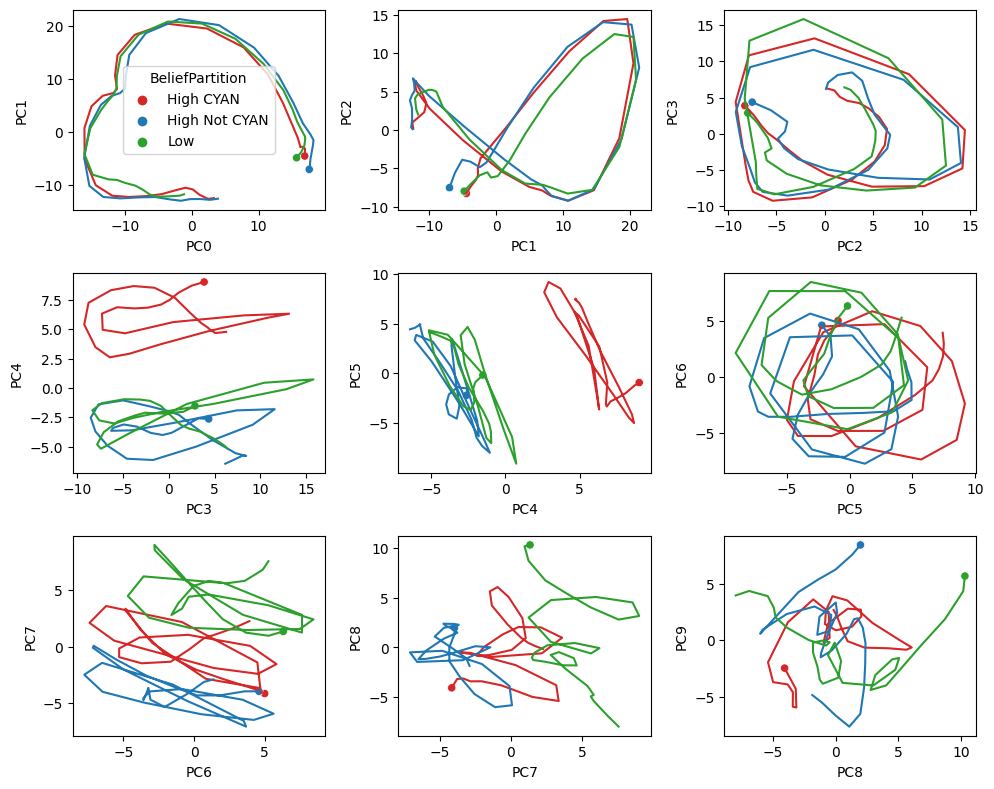

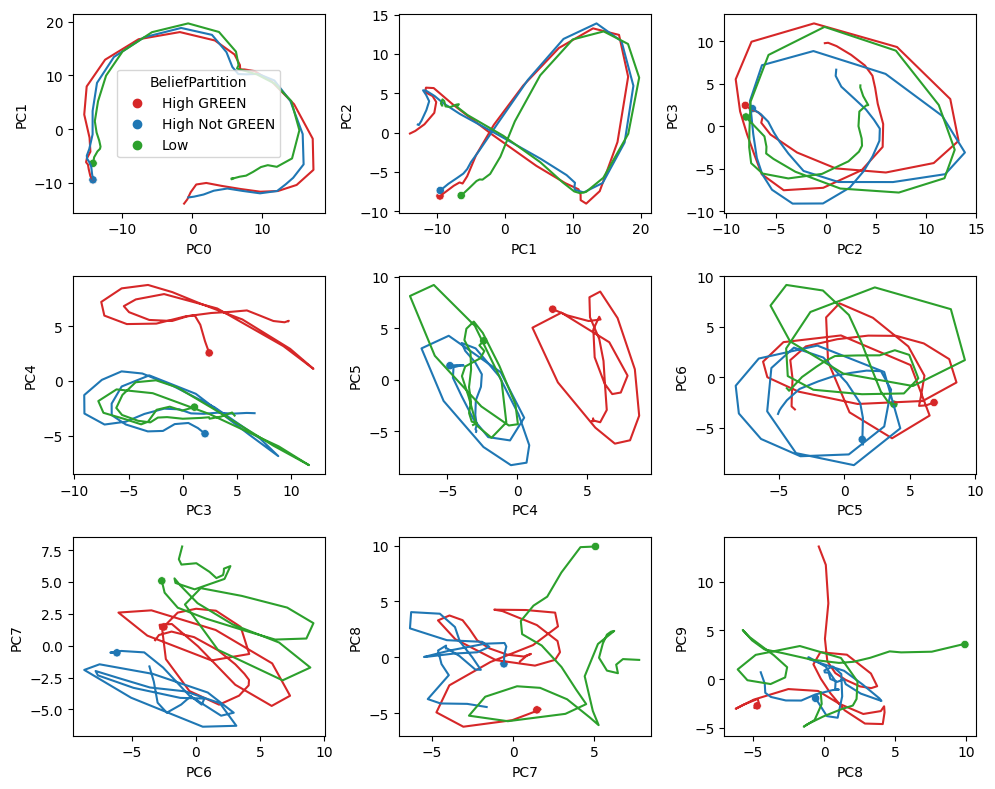

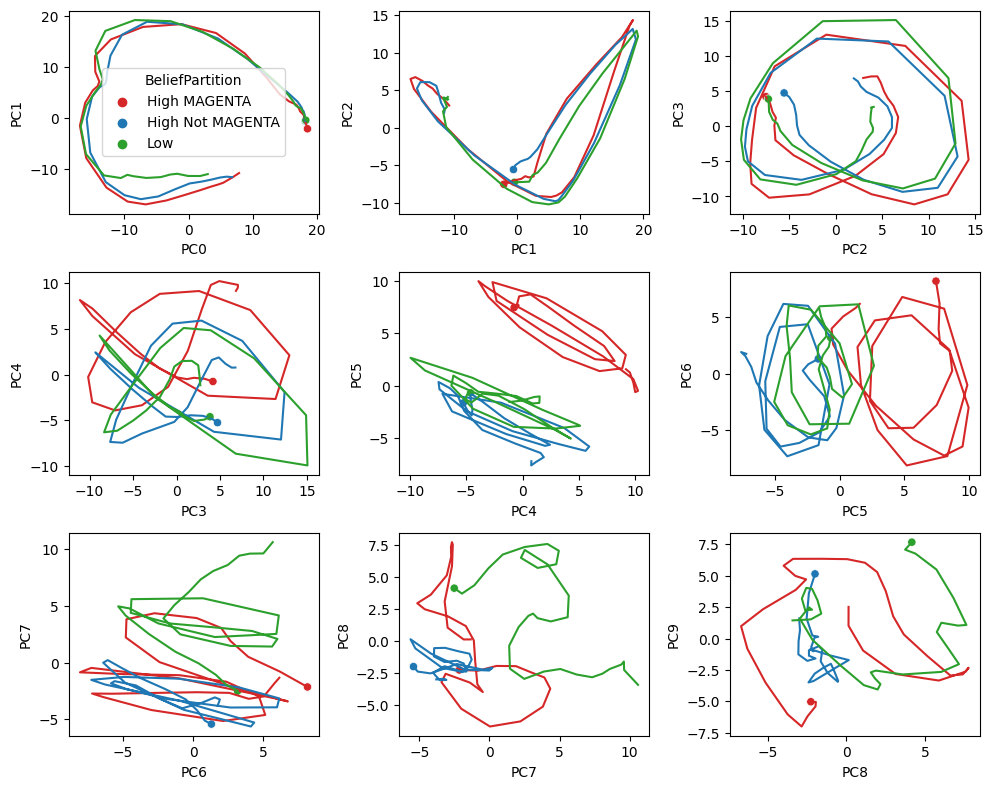

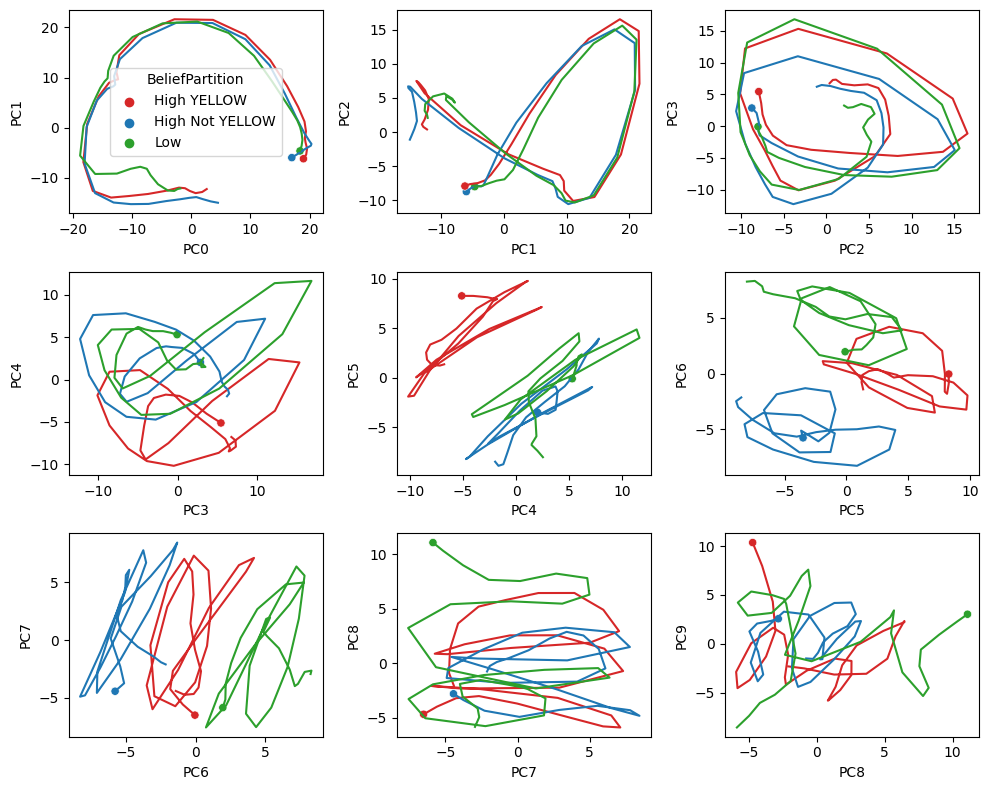

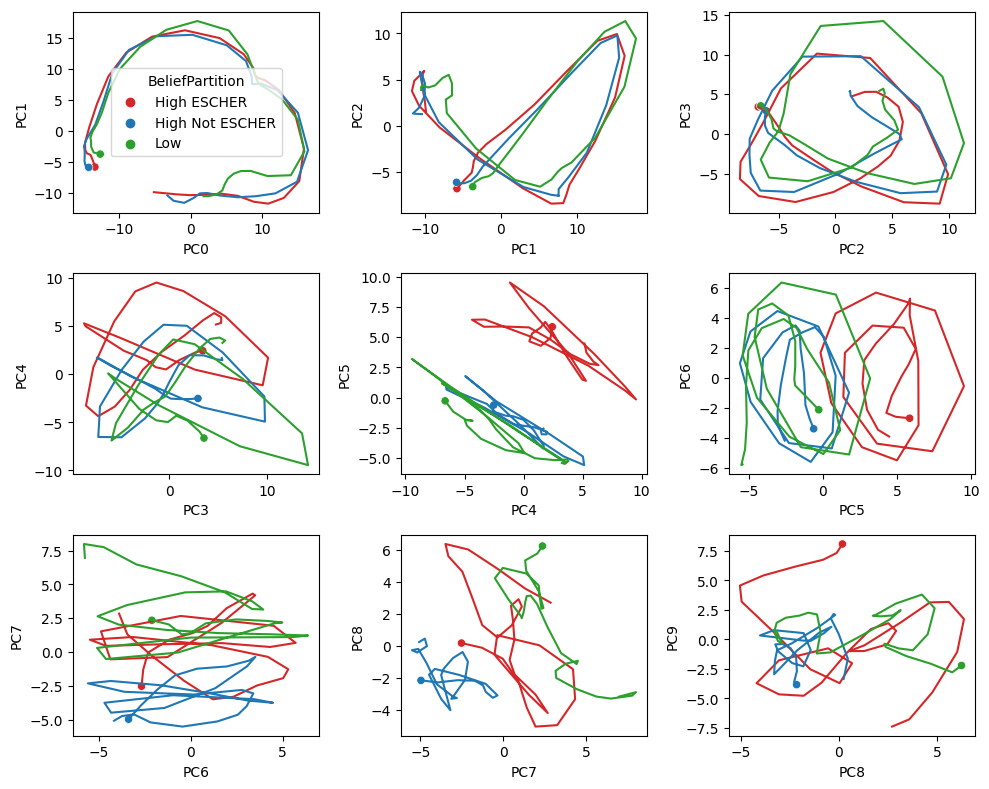

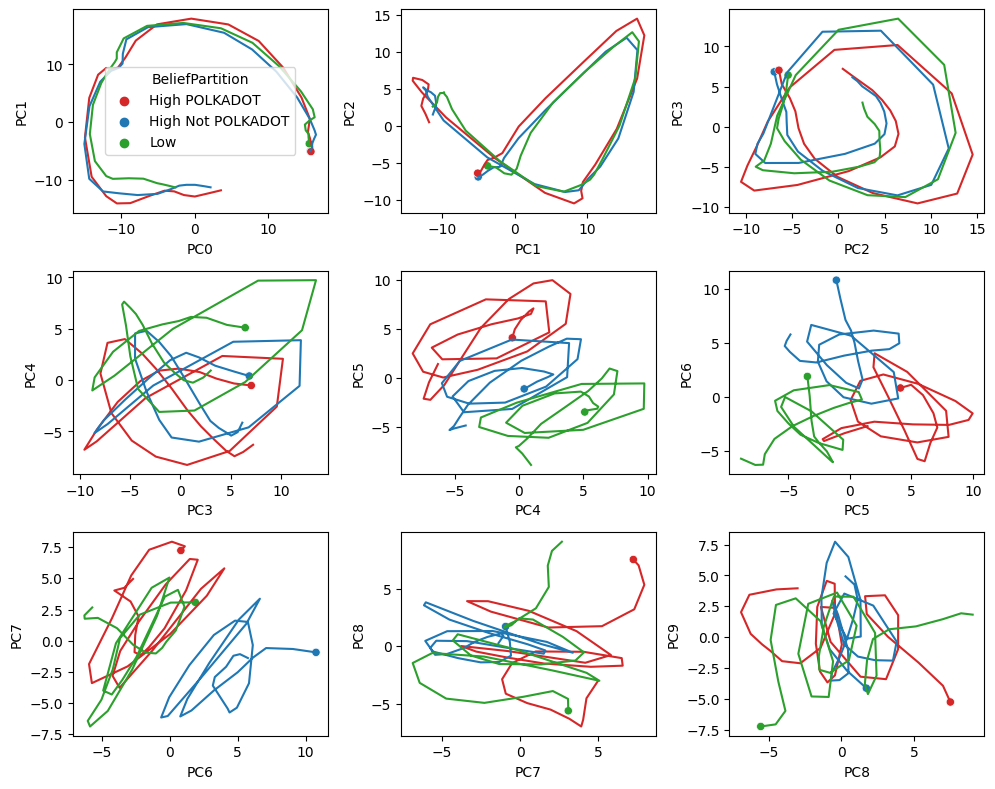

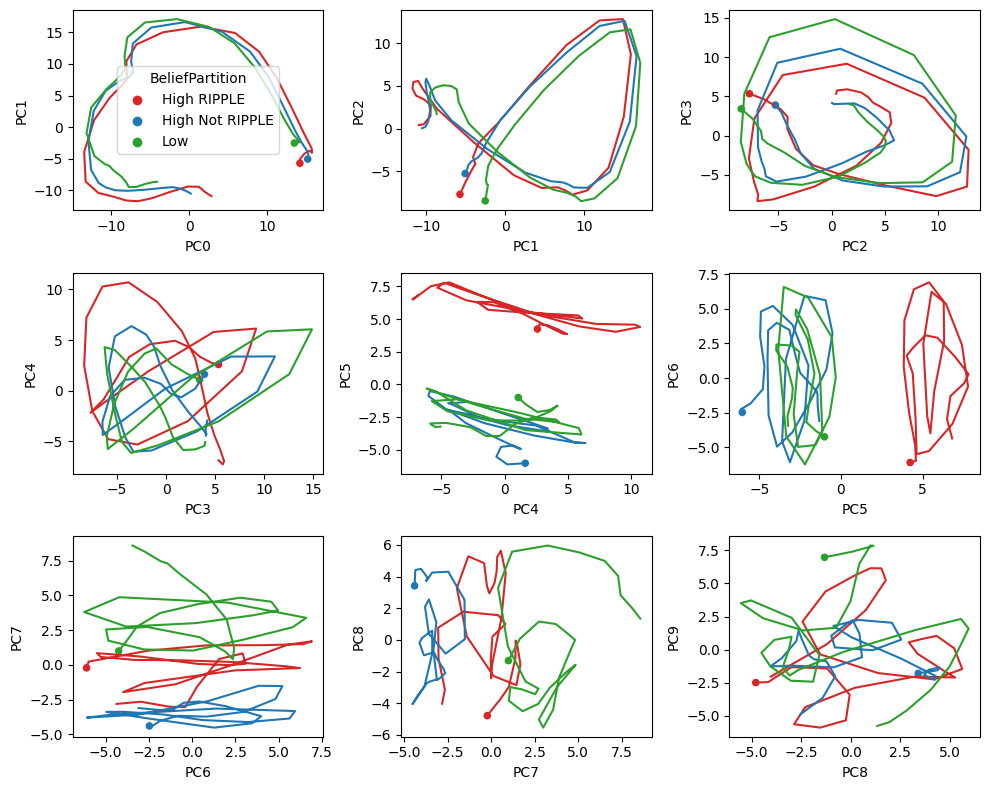

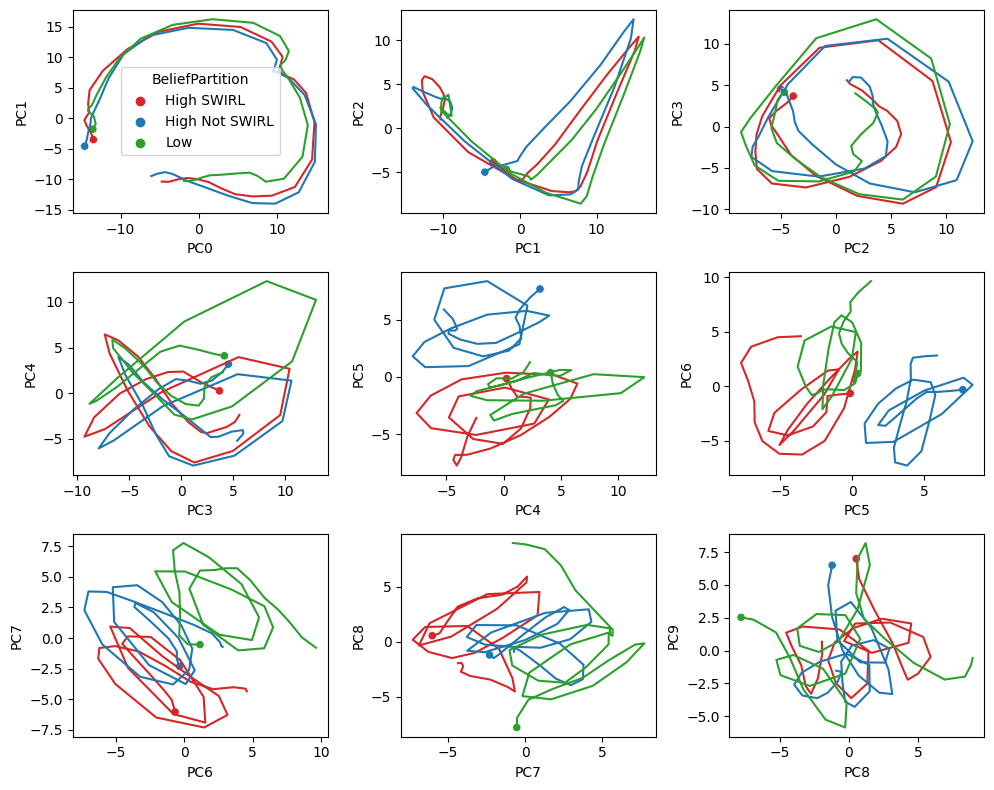

In [56]:
for i in range(12):
    feat_row = feats.iloc[i]
    args.feat = feat_row.feat
    order = [f"High {args.feat}", f"High Not {args.feat}", "Low"]
    colors = ["tab:red", "tab:blue", "tab:green"]
    feat_sessions = valid_sess[valid_sess.session_name.isin(feat_row.sessions)]
    res = pd.concat(feat_sessions.progress_apply(lambda x: load_data(x.session_name, args, return_merged=True), axis=1).values)

    pca_res, _ = compute_cond_averaged_pc_trajectories(res, "BeliefPartition")

    fig, axs = plt.subplots(3, 3, figsize=(10, 8))
    for i in range(9):
        ax = axs[i // 3, i % 3]
        sns.lineplot(pca_res, x=f"PC{i}", y=f"PC{i+1}", hue="BeliefPartition", sort=False, legend=False, ax=ax, hue_order=order, palette=colors)
        
        last_point = pca_res.groupby("BeliefPartition").apply(lambda x: x.loc[x.Time.idxmax()])
        sns.scatterplot(last_point, x=f"PC{i}", y=f"PC{i+1}", hue="BeliefPartition", ax=ax, hue_order=order, palette=colors)
        if i != 0:
            ax.get_legend().remove()
    fig.tight_layout()

In [1]:
pca_res["TimePos"] = pca_res["Time"] + 1

NameError: name 'pca_res' is not defined

In [2]:
fig = px.scatter_3d(
    pca_res, 
    x='PC3', y='PC4', z='PC5',
    color='BeliefPartition', 
    opacity=1,
    size='TimePos',
    # color_discrete_sequence=colors
)
fig.show()

NameError: name 'px' is not defined